# open FIA data points

In [1]:
from glob import glob
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon
import folium
from folium.plugins import MarkerCluster
import binascii
import os
import sys
sys.path.append('/content')

%matplotlib inline

# Standard packages
import tempfile
import warnings
import urllib
import shutil
import os

# Workaround for a problem in older rasterio versions
os.environ["CURL_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt" 

# Less standard, but still pip- or conda-installable
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rtree
import shapely
import pickle

# pip install progressbar2, not progressbar
import progressbar

from geopy.geocoders import Nominatim
from rasterio.windows import Window 
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

from src.azuretools import *

latest_wkid = 3857
crs = "EPSG:4326"

# Storage locations are documented at http://aka.ms/ai4edata-naip
blob_root = 'https://naipblobs.blob.core.windows.net/naip'

index_files = ["tile_index.dat", "tile_index.idx", "tiles.p"]
index_blob_root = 'https://naipblobs.blob.core.windows.net/naip-index/rtree/'
temp_dir = os.path.join(tempfile.gettempdir(),'naip')
os.makedirs(temp_dir,exist_ok=True)

# Spatial index that maps lat/lon to NAIP tiles; we'll load this when we first 
# need to access it.
index = None
if index is None:
    index = NAIPTileIndex()
# URL where we've stashed a geojson file with the boundaries of Maryland.  Why do we
# need the boundaries of Maryland?  It's a surprise, you'll have to keep reading to find
# out.
warnings.filterwarnings("ignore")
%matplotlib inline

  5% (4202496 of 82944000) |             | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (82944000 of 82944000) |############| Elapsed Time: 0:00:01 Time:  0:00:01
100% (445652 of 445652) |################| Elapsed Time: 0:00:00 Time:  0:00:00
  3% (6799360 of 178955434) |            | Elapsed Time: 0:00:00 ETA:  00:00:00

...done, 82944000 bytes.

100% (178955434 of 178955434) |##########| Elapsed Time: 0:00:02 Time:  0:00:02


...done, 178955434 bytes.


In [11]:
blob = '/home/datablob'
fiafile = f'{blob}/fia_no_pltcn.csv'
plots = gpd.GeoDataFrame(pd.read_csv(fiafile))
plots.Latitude = plots.LAT.astype('float')
plots.Longitude = plots.LON.astype('float')
geometry = [Point(xy) for xy in zip(plots.Longitude, plots.Latitude)]
crs = {'init': 'epsg:4326'} 
geo_df = gpd.GeoDataFrame(plots, crs=crs, geometry=geometry)

#subset by STATECD
statecd = pd.read_csv(glob(f'{blob}/supp_data/*.csv')[0])
#query = 'CA'
query = 'OR'

code = statecd[statecd['STATEAB']== query]['STATECD'].values[0]
subdf = geo_df[geo_df['STATECD']==code]
fields = ['INDEX', 'INVYR', 'LAT', 'LON']
subdf = subdf.astype({'LAT':'float', 'LON':'float', 'INVYR':'int32'})
subdf = gpd.GeoDataFrame(subdf, geometry=gpd.points_from_xy(subdf.LON, subdf.LAT))
subdf = subdf.set_crs(epsg=4326)
subdf = subdf.rename(columns={'Unnamed: 0':'INDEX'})

#statebounds for reducing query on cloud
statebounds = glob(f'{blob}/supp_data/shp/*.shp')[0]
states = gpd.read_file(statebounds)
state = states[states['STPOSTAL']==query]
state_shape = state.geometry

In [ ]:
from pathlib import Path
from PIL import Image
import fiona
import fiona.transform
import requests
import json

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

flatten = lambda l: [item for sublist in l for item in sublist]

####################################

ref_list = []
skip_list = []
batch_size = 5000 
for batch_number, sample in enumerate(chunker(subdf, batch_size)):

    image_crops = [] # place to save the images we grab
    image_points = [] # place to save the lat/lons
    image_skips = []
    ids = []
    year_selected = []
    ref = []
    for i, (_,point) in tqdm(enumerate(sample.iterrows()),total=len(sample)):

        lon, lat = point.geometry.x, point.geometry.y

        # Find the filenames that intersect with our lat/lon
        naip_files = index.lookup_tile(lat, lon) 

        if naip_files is None or len(naip_files) == 0:
            print('No intersection, skipping point {}'.format(i))
            image_skips.append(i)
            ref.append('None')
            continue

        # check for the matching or closest year
        query_year = point.INVYR
        naip_years = np.array([int(n.split('/')[2]) for n in naip_files])
        closest = min(naip_years, key=lambda x:abs(x-query_year))
        year_selected.append(closest)
        match_idx = np.where(naip_years==closest)[0][0]

        image_url = blob_root + '/' + naip_files[match_idx] 

        with rasterio.open(image_url) as f:

            # Each NAIP tile has its own coordinate system that is *not* lat/lon 
            crs = f.crs 

            # This object will let us convert between tile coordinates (these will be local
            # state CRS) and tile offsets (i.e. pixel indices)
            transform = f.transform 

            # Convert our lat/lon point to the local NAIP coordinate system
            x_tile_crs, y_tile_crs = fiona.transform.transform("epsg:4326",\
                                                               crs.to_string(),\
                                                               [lon],[lat]) 
            x_tile_crs = x_tile_crs[0]
            y_tile_crs = y_tile_crs[0]

            # Convert our new x/y coordinates into pixel indices
            x_tile_offset, y_tile_offset = ~transform * (x_tile_crs, y_tile_crs) 
            x_tile_offset = int(np.floor(x_tile_offset))
            y_tile_offset = int(np.floor(y_tile_offset))        

            # The secret sauce: only read data from a 256x256 window centered on our point
            image_crop = f.read(window=Window(x_tile_offset-128, y_tile_offset-128, 256, 256)) 
            image_crop = np.rollaxis(image_crop, 0, 3)

        # Sometimes our point will be on the edge of a NAIP tile, and our windowed reader above
        # will not actually return a 256x256 chunk of data we could handle this nicely by going 
        # back up to the `naip_files` list and trying to read from one of the other tiles - 
        # because the NAIP tiles have overlap with one another, there should exist an intersecting
        # tile with the full window.
        if (image_crop.shape[0] == 256) and (image_crop.shape[1] == 256):
            image_crops.append(image_crop)
            image_points.append(point)
            ref.append(image_url)
        else:
            print('Our crop was likely at the edge of a NAIP tile, skipping point {}'.format(i))
            image_skips.append(i)
            ref.append('None')
    # ...for each point
    #now we want to save the images in a directory
    labels = [s['INDEX'] for i,(_,s) in enumerate(sample.iterrows()) if i not in image_skips]
    ref_data = [r for i,r in enumerate(ref) if i not in image_skips] 
    dataset = 'NAIP'
    write_dirc = f'{blob}/training_tiles/{dataset}/{query}'
    Path(write_dirc).mkdir(parents=True, exist_ok=True)
    for i,l in enumerate(labels):
        outfile = f'{write_dirc}/{l}.tif'
        outimage = Image.fromarray(image_crops[i][:,:,:3]) 
        outimage.save(outfile)
    ref_list.append(ref)
    skip_list.append(image_skips)
    
ref_urls = flatten(ref_list)
outname = f'{blob}/training_tiles/{dataset}/{query}_urls.csv'
subdf[['INDEX','INVYR', 'REF_URL']].to_csv(outname, index='False')

  0%|          | 4/5000 [00:01<41:20,  2.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3


  1%|          | 42/5000 [00:18<33:14,  2.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 41


  1%|          | 53/5000 [00:22<32:53,  2.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 52


  1%|          | 59/5000 [00:24<34:34,  2.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 58


  3%|▎         | 157/5000 [01:03<31:05,  2.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 156


  3%|▎         | 167/5000 [01:07<29:27,  2.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 166


  4%|▍         | 215/5000 [01:27<30:46,  2.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 214


  4%|▍         | 221/5000 [01:30<30:49,  2.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 220


  5%|▍         | 240/5000 [01:37<31:18,  2.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 239


  5%|▍         | 248/5000 [01:40<28:30,  2.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 247


  5%|▍         | 249/5000 [01:41<30:40,  2.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 248


  5%|▌         | 260/5000 [01:45<29:16,  2.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 259


  6%|▌         | 279/5000 [01:53<28:16,  2.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 278


  6%|▌         | 297/5000 [02:00<30:21,  2.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 296


  6%|▌         | 300/5000 [02:01<32:17,  2.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 299


  7%|▋         | 327/5000 [02:12<28:23,  2.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 326


  7%|▋         | 329/5000 [02:13<29:48,  2.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 328


  7%|▋         | 340/5000 [02:17<32:07,  2.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 339


  7%|▋         | 354/5000 [02:23<31:16,  2.48it/s]

No tile intersections
No intersection, skipping point 354
No tile intersections
No intersection, skipping point 355
No tile intersections
No intersection, skipping point 356
No tile intersections
No intersection, skipping point 357


  7%|▋         | 364/5000 [02:25<30:35,  2.53it/s]

No tile intersections
No intersection, skipping point 364


  7%|▋         | 366/5000 [02:26<26:24,  2.92it/s]

No tile intersections
No intersection, skipping point 366
No tile intersections
No intersection, skipping point 367


  8%|▊         | 378/5000 [02:30<29:42,  2.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 377


  8%|▊         | 394/5000 [02:36<29:14,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 393


  9%|▊         | 431/5000 [02:51<30:41,  2.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 430


 10%|▉         | 476/5000 [03:09<29:50,  2.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 475


 10%|█         | 501/5000 [03:19<31:12,  2.40it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 500


 10%|█         | 515/5000 [03:25<31:21,  2.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 514


 11%|█         | 546/5000 [03:37<29:10,  2.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 545


 11%|█▏        | 563/5000 [03:44<28:41,  2.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 562


 12%|█▏        | 583/5000 [03:51<28:12,  2.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 582


 12%|█▏        | 585/5000 [03:52<23:10,  3.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 584


 13%|█▎        | 626/5000 [04:07<26:57,  2.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 625


 13%|█▎        | 631/5000 [04:09<29:16,  2.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 630


 15%|█▍        | 746/5000 [04:55<28:08,  2.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 745


 16%|█▌        | 799/5000 [05:16<27:03,  2.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 798


 16%|█▌        | 804/5000 [05:18<20:54,  3.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 802


 16%|█▌        | 806/5000 [05:19<25:25,  2.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 805


 16%|█▋        | 821/5000 [05:25<27:39,  2.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 820


 17%|█▋        | 840/5000 [05:32<30:00,  2.31it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 839


 17%|█▋        | 872/5000 [05:45<26:24,  2.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 871


 18%|█▊        | 880/5000 [05:49<22:31,  3.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 878


 18%|█▊        | 889/5000 [05:52<28:53,  2.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 888


 18%|█▊        | 897/5000 [05:55<26:55,  2.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 896


 19%|█▊        | 928/5000 [06:08<26:39,  2.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 927


 19%|█▉        | 945/5000 [06:15<25:47,  2.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 944


 19%|█▉        | 954/5000 [06:19<27:02,  2.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 953


 19%|█▉        | 973/5000 [06:26<27:57,  2.40it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 972


 20%|██        | 1007/5000 [06:41<25:52,  2.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1006


 21%|██        | 1031/5000 [06:51<26:32,  2.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1030


 21%|██        | 1036/5000 [06:53<28:58,  2.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1035


 21%|██        | 1058/5000 [07:05<27:12,  2.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1057


 22%|██▏       | 1078/5000 [07:13<25:04,  2.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1077


 22%|██▏       | 1088/5000 [07:17<26:43,  2.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1087


 22%|██▏       | 1094/5000 [07:19<25:50,  2.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1093


 22%|██▏       | 1116/5000 [07:29<29:01,  2.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1115


 23%|██▎       | 1137/5000 [07:37<25:30,  2.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1136


 23%|██▎       | 1165/5000 [07:49<33:48,  1.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1164


 23%|██▎       | 1171/5000 [07:51<25:47,  2.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1170


 24%|██▍       | 1188/5000 [07:59<31:37,  2.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1187


 24%|██▍       | 1195/5000 [08:02<24:58,  2.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1194


 24%|██▍       | 1210/5000 [08:09<26:04,  2.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1209


 25%|██▍       | 1242/5000 [08:22<25:20,  2.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1242


 26%|██▌       | 1303/5000 [08:47<25:14,  2.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1302


 26%|██▋       | 1325/5000 [08:55<23:11,  2.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1324


 27%|██▋       | 1358/5000 [09:08<26:33,  2.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1357


 27%|██▋       | 1360/5000 [09:09<25:34,  2.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1359


 27%|██▋       | 1369/5000 [09:13<22:32,  2.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1368


 27%|██▋       | 1372/5000 [09:14<23:11,  2.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1371


 28%|██▊       | 1378/5000 [09:16<19:51,  3.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1377


 29%|██▉       | 1441/5000 [09:41<24:31,  2.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1440


 29%|██▉       | 1445/5000 [09:42<21:50,  2.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1444


 30%|██▉       | 1492/5000 [10:00<20:46,  2.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1491


 30%|██▉       | 1499/5000 [10:03<25:10,  2.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1498


 31%|███       | 1550/5000 [10:20<21:52,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1549


 31%|███       | 1555/5000 [10:22<17:29,  3.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1554


 31%|███▏      | 1571/5000 [10:28<20:27,  2.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1570


 32%|███▏      | 1576/5000 [10:30<22:35,  2.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1575


 33%|███▎      | 1637/5000 [10:55<23:12,  2.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1636


 33%|███▎      | 1640/5000 [10:56<22:22,  2.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1639


 33%|███▎      | 1643/5000 [10:57<22:15,  2.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1642


 33%|███▎      | 1654/5000 [11:02<22:38,  2.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1653


 34%|███▎      | 1684/5000 [11:14<21:30,  2.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1683


 35%|███▍      | 1740/5000 [11:35<16:40,  3.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1739


 35%|███▍      | 1747/5000 [11:38<20:09,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1746


 36%|███▋      | 1813/5000 [12:03<21:27,  2.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1812


 37%|███▋      | 1847/5000 [12:17<16:36,  3.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1846


 37%|███▋      | 1854/5000 [12:20<19:54,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1853


 38%|███▊      | 1891/5000 [12:33<21:47,  2.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1890


 38%|███▊      | 1892/5000 [12:34<22:03,  2.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1891


 38%|███▊      | 1917/5000 [12:43<19:45,  2.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1916


 39%|███▉      | 1945/5000 [12:53<20:13,  2.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1944


 40%|███▉      | 1978/5000 [13:06<20:27,  2.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1977


 40%|███▉      | 1988/5000 [13:10<19:54,  2.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1987


 42%|████▏     | 2105/5000 [13:58<20:17,  2.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2104


 42%|████▏     | 2109/5000 [13:59<20:59,  2.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2108


 43%|████▎     | 2140/5000 [14:10<12:21,  3.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2139


 43%|████▎     | 2149/5000 [14:14<21:40,  2.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2148


 44%|████▎     | 2180/5000 [14:26<18:43,  2.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2179


 44%|████▎     | 2187/5000 [14:29<19:57,  2.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2186


 44%|████▍     | 2221/5000 [14:43<19:33,  2.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2220


 45%|████▍     | 2230/5000 [14:46<15:41,  2.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2228


 45%|████▍     | 2246/5000 [14:52<15:03,  3.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2245


 45%|████▌     | 2263/5000 [14:59<19:07,  2.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2262


 45%|████▌     | 2266/5000 [15:00<15:27,  2.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2265


 46%|████▌     | 2290/5000 [15:10<15:46,  2.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2289


 47%|████▋     | 2326/5000 [15:22<16:30,  2.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2325


 47%|████▋     | 2333/5000 [15:25<15:44,  2.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2332


 47%|████▋     | 2336/5000 [15:26<14:02,  3.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2334


 47%|████▋     | 2343/5000 [15:29<17:45,  2.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2342


 47%|████▋     | 2364/5000 [15:36<15:19,  2.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2363


 47%|████▋     | 2374/5000 [15:40<17:33,  2.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2373


 48%|████▊     | 2409/5000 [15:56<17:34,  2.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2408


 49%|████▉     | 2440/5000 [16:09<17:14,  2.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2439


 49%|████▉     | 2467/5000 [16:19<16:37,  2.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2466


 50%|████▉     | 2478/5000 [16:24<16:11,  2.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2478


 50%|████▉     | 2490/5000 [16:28<16:14,  2.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2489


 50%|█████     | 2516/5000 [16:39<16:37,  2.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2515


 50%|█████     | 2519/5000 [16:40<15:55,  2.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2518


 50%|█████     | 2520/5000 [16:40<15:13,  2.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2519


 50%|█████     | 2521/5000 [16:41<15:31,  2.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2520


 51%|█████     | 2531/5000 [16:45<17:18,  2.38it/s]

No tile intersections
No intersection, skipping point 2531
No tile intersections
No intersection, skipping point 2532
No tile intersections
No intersection, skipping point 2533


 51%|█████     | 2547/5000 [16:50<15:36,  2.62it/s]

No tile intersections
No intersection, skipping point 2547


 51%|█████▏    | 2563/5000 [16:56<16:42,  2.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2562


 51%|█████▏    | 2566/5000 [16:57<15:15,  2.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2565


 51%|█████▏    | 2573/5000 [17:00<17:01,  2.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2572


 53%|█████▎    | 2630/5000 [17:22<13:33,  2.91it/s]

No tile intersections
No intersection, skipping point 2630


 54%|█████▎    | 2678/5000 [17:42<15:58,  2.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2677


 54%|█████▍    | 2713/5000 [17:56<12:43,  2.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2712


 55%|█████▍    | 2735/5000 [18:04<10:21,  3.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2733


 55%|█████▌    | 2756/5000 [18:11<14:28,  2.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2755


 56%|█████▌    | 2808/5000 [18:31<14:48,  2.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2807


 56%|█████▋    | 2816/5000 [18:34<11:50,  3.07it/s]

No tile intersections
No intersection, skipping point 2816


 57%|█████▋    | 2837/5000 [18:42<12:15,  2.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2835


 57%|█████▋    | 2846/5000 [18:46<13:38,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2845


 57%|█████▋    | 2860/5000 [18:51<13:18,  2.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2859


 58%|█████▊    | 2881/5000 [18:59<12:29,  2.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2880


 58%|█████▊    | 2898/5000 [19:06<12:29,  2.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2897


 58%|█████▊    | 2918/5000 [19:13<13:28,  2.57it/s]

No tile intersections
No intersection, skipping point 2918


 58%|█████▊    | 2923/5000 [19:15<13:06,  2.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2922


 59%|█████▊    | 2927/5000 [19:16<12:29,  2.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2926


 60%|█████▉    | 2984/5000 [19:37<12:55,  2.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2983


 60%|█████▉    | 2991/5000 [19:40<12:12,  2.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2990


 61%|██████    | 3026/5000 [19:54<19:09,  1.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3025


 62%|██████▏   | 3081/5000 [20:15<11:14,  2.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3080


 62%|██████▏   | 3091/5000 [20:19<11:42,  2.72it/s]

No tile intersections
No intersection, skipping point 3091


 62%|██████▏   | 3115/5000 [20:28<12:01,  2.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3114


 63%|██████▎   | 3127/5000 [20:32<08:15,  3.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3126


 63%|██████▎   | 3170/5000 [20:48<12:16,  2.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3169


 64%|██████▍   | 3204/5000 [21:01<11:49,  2.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3203


 66%|██████▌   | 3291/5000 [21:32<08:32,  3.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3289


 66%|██████▌   | 3295/5000 [21:33<08:57,  3.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3294


 67%|██████▋   | 3351/5000 [21:54<07:12,  3.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3349


 67%|██████▋   | 3361/5000 [21:58<10:33,  2.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3360


 67%|██████▋   | 3364/5000 [21:59<10:25,  2.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3363


 69%|██████▉   | 3441/5000 [22:29<10:49,  2.40it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3440


 69%|██████▉   | 3466/5000 [22:39<10:03,  2.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3465


 70%|██████▉   | 3478/5000 [22:43<09:24,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3477


 70%|██████▉   | 3492/5000 [22:48<09:23,  2.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3491


 70%|███████   | 3515/5000 [22:56<09:47,  2.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3514


 71%|███████   | 3541/5000 [23:07<09:34,  2.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3540


 71%|███████   | 3542/5000 [23:08<09:21,  2.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3541


 72%|███████▏  | 3585/5000 [23:24<09:01,  2.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3584


 72%|███████▏  | 3589/5000 [23:25<08:13,  2.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3588


 73%|███████▎  | 3649/5000 [23:49<08:15,  2.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3648


 73%|███████▎  | 3665/5000 [23:55<09:23,  2.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3664


 73%|███████▎  | 3667/5000 [23:56<08:50,  2.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3666


 73%|███████▎  | 3672/5000 [23:58<08:34,  2.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3671


 74%|███████▎  | 3676/5000 [24:00<09:02,  2.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3675


 74%|███████▎  | 3686/5000 [24:03<06:07,  3.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3685


 74%|███████▍  | 3698/5000 [24:07<06:49,  3.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3696


 74%|███████▍  | 3713/5000 [24:12<07:47,  2.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3712


 74%|███████▍  | 3720/5000 [24:15<07:59,  2.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3719


 74%|███████▍  | 3725/5000 [24:16<05:33,  3.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3723
Our crop was likely at the edge of a NAIP tile, skipping point 3724


 75%|███████▍  | 3730/5000 [24:18<05:02,  4.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3728


 75%|███████▌  | 3755/5000 [24:26<07:13,  2.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3753


 75%|███████▌  | 3767/5000 [24:30<07:05,  2.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3766


 76%|███████▋  | 3825/5000 [24:51<06:55,  2.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3824


 77%|███████▋  | 3849/5000 [25:01<06:49,  2.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3848


 77%|███████▋  | 3863/5000 [25:06<07:04,  2.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3862


 78%|███████▊  | 3908/5000 [25:24<08:13,  2.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3907


 78%|███████▊  | 3920/5000 [25:29<06:51,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3919


 79%|███████▊  | 3931/5000 [25:33<07:11,  2.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3930


 79%|███████▉  | 3947/5000 [25:40<07:06,  2.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3946


 79%|███████▉  | 3965/5000 [25:47<06:48,  2.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3964


 79%|███████▉  | 3966/5000 [25:48<06:32,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3965


 79%|███████▉  | 3967/5000 [25:48<06:53,  2.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3966


 80%|████████  | 4001/5000 [26:02<06:46,  2.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4000


 80%|████████  | 4011/5000 [26:06<07:38,  2.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4010


 80%|████████  | 4013/5000 [26:07<06:55,  2.37it/s]

No tile intersections
No intersection, skipping point 4013
No tile intersections
No intersection, skipping point 4014


 80%|████████  | 4017/5000 [26:08<05:57,  2.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4016
No tile intersections
No intersection, skipping point 4017
No tile intersections
No intersection, skipping point 4018


 80%|████████  | 4020/5000 [26:08<04:47,  3.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4019


 81%|████████  | 4058/5000 [26:24<06:23,  2.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4057


 83%|████████▎ | 4149/5000 [26:59<04:58,  2.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4148


 83%|████████▎ | 4173/5000 [27:09<05:51,  2.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4172


 84%|████████▎ | 4178/5000 [27:11<04:58,  2.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4177


 84%|████████▎ | 4186/5000 [27:14<04:26,  3.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4184


 84%|████████▍ | 4197/5000 [27:18<05:10,  2.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4196


 85%|████████▍ | 4226/5000 [27:29<04:57,  2.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4225


 85%|████████▍ | 4227/5000 [27:29<05:03,  2.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4226


 85%|████████▍ | 4228/5000 [27:29<05:01,  2.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4227


 85%|████████▍ | 4240/5000 [27:33<02:59,  4.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4239


 86%|████████▌ | 4289/5000 [27:50<03:13,  3.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4288


 86%|████████▌ | 4299/5000 [27:53<02:50,  4.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4298


 86%|████████▋ | 4315/5000 [27:58<03:25,  3.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4314


 86%|████████▋ | 4316/5000 [27:58<03:41,  3.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4315


 88%|████████▊ | 4378/5000 [28:19<03:55,  2.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4377


 88%|████████▊ | 4392/5000 [28:24<04:12,  2.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4391


 88%|████████▊ | 4399/5000 [28:27<04:17,  2.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4398


 90%|████████▉ | 4492/5000 [29:02<03:11,  2.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4491


 90%|█████████ | 4521/5000 [29:12<02:52,  2.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4520


 91%|█████████ | 4537/5000 [29:18<02:51,  2.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4536


 91%|█████████ | 4560/5000 [29:26<02:44,  2.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4559


 91%|█████████▏| 4566/5000 [29:29<02:44,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4565


 91%|█████████▏| 4573/5000 [29:31<02:38,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4572


 93%|█████████▎| 4651/5000 [30:01<02:06,  2.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4650


 94%|█████████▍| 4701/5000 [30:19<01:18,  3.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4699


 94%|█████████▍| 4713/5000 [30:23<01:29,  3.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4711


 96%|█████████▌| 4809/5000 [30:56<00:53,  3.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4807


 96%|█████████▋| 4819/5000 [30:59<01:07,  2.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4818


 97%|█████████▋| 4841/5000 [31:07<00:48,  3.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4839


 97%|█████████▋| 4845/5000 [31:08<00:57,  2.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4844


 97%|█████████▋| 4851/5000 [31:11<00:50,  2.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4849


 97%|█████████▋| 4861/5000 [31:15<00:46,  3.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4859


 98%|█████████▊| 4900/5000 [31:29<00:35,  2.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4899


 98%|█████████▊| 4912/5000 [31:33<00:26,  3.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4910


 98%|█████████▊| 4919/5000 [31:36<00:30,  2.69it/s]

No tile intersections
No intersection, skipping point 4919
No tile intersections
No intersection, skipping point 4920


 98%|█████████▊| 4925/5000 [31:37<00:25,  2.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4924


 99%|█████████▊| 4929/5000 [31:39<00:24,  2.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4927


 99%|█████████▉| 4942/5000 [31:44<00:23,  2.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4941


 99%|█████████▉| 4965/5000 [31:53<00:13,  2.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4964


  0%|          | 19/5000 [00:06<32:00,  2.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 18


  1%|          | 28/5000 [00:09<25:07,  3.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 27


  1%|          | 48/5000 [00:17<33:07,  2.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 47


  1%|          | 50/5000 [00:18<32:46,  2.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 49


  1%|          | 51/5000 [00:18<31:04,  2.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 50


  1%|          | 57/5000 [00:20<30:10,  2.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 56


  1%|▏         | 64/5000 [00:23<31:39,  2.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 63


  3%|▎         | 133/5000 [00:50<26:46,  3.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 132


  3%|▎         | 154/5000 [00:57<25:13,  3.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 153


  4%|▎         | 175/5000 [01:04<23:51,  3.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 173


  4%|▎         | 187/5000 [01:08<30:18,  2.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 186


  4%|▍         | 194/5000 [01:11<31:54,  2.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 193


  4%|▍         | 212/5000 [01:18<27:47,  2.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 211


  4%|▍         | 216/5000 [01:19<24:27,  3.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 215


  4%|▍         | 219/5000 [01:20<21:28,  3.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 217


  5%|▍         | 249/5000 [01:30<29:15,  2.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 248


  5%|▌         | 257/5000 [01:33<26:34,  2.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 256


  6%|▌         | 275/5000 [01:39<29:00,  2.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 274


  6%|▌         | 276/5000 [01:39<29:46,  2.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 275


  6%|▌         | 278/5000 [01:40<29:48,  2.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 277


  6%|▌         | 283/5000 [01:42<21:18,  3.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 281


  6%|▋         | 314/5000 [01:52<27:32,  2.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 313


  7%|▋         | 329/5000 [01:58<28:53,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 328


  7%|▋         | 330/5000 [01:58<29:24,  2.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 329


  7%|▋         | 364/5000 [02:11<28:22,  2.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 363


  7%|▋         | 367/5000 [02:12<25:54,  2.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 366


  8%|▊         | 394/5000 [02:21<21:47,  3.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 393


  9%|▉         | 462/5000 [02:47<29:19,  2.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 461


 10%|▉         | 479/5000 [02:53<25:09,  2.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 478


 10%|▉         | 482/5000 [02:54<25:47,  2.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 481


 11%|█         | 541/5000 [03:16<20:21,  3.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 540


 11%|█         | 554/5000 [03:21<24:27,  3.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 553


 12%|█▏        | 617/5000 [03:44<28:58,  2.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 616


 13%|█▎        | 656/5000 [03:58<28:23,  2.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 655


 14%|█▎        | 685/5000 [04:07<21:21,  3.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 684


 14%|█▍        | 693/5000 [04:10<25:26,  2.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 692


 15%|█▍        | 731/5000 [04:24<24:09,  2.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 730


 15%|█▍        | 746/5000 [04:29<20:09,  3.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 745


 16%|█▌        | 809/5000 [04:50<22:17,  3.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 808


 16%|█▋        | 820/5000 [04:53<15:15,  4.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 818


 16%|█▋        | 825/5000 [04:54<14:48,  4.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 824


 17%|█▋        | 856/5000 [05:05<27:36,  2.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 855


 18%|█▊        | 894/5000 [05:20<27:32,  2.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 893


 18%|█▊        | 896/5000 [05:21<23:32,  2.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 895


 18%|█▊        | 913/5000 [05:27<19:13,  3.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 912


 18%|█▊        | 919/5000 [05:29<24:15,  2.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 918


 19%|█▉        | 940/5000 [05:36<25:20,  2.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 939


 20%|█▉        | 975/5000 [05:49<18:50,  3.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 974


 20%|██        | 1002/5000 [05:58<24:43,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1001


 20%|██        | 1014/5000 [06:02<17:28,  3.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1013


 21%|██        | 1049/5000 [06:17<20:56,  3.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1047
Our crop was likely at the edge of a NAIP tile, skipping point 1048


 22%|██▏       | 1116/5000 [06:41<24:23,  2.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1115


 23%|██▎       | 1140/5000 [06:50<24:38,  2.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1139


 24%|██▍       | 1211/5000 [07:14<18:15,  3.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1209


 25%|██▍       | 1233/5000 [07:21<19:34,  3.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1232


 25%|██▍       | 1235/5000 [07:21<21:16,  2.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1234


 25%|██▌       | 1260/5000 [07:30<18:44,  3.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1259


 26%|██▋       | 1320/5000 [07:53<21:42,  2.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1319


 26%|██▋       | 1323/5000 [07:53<18:11,  3.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1322


 27%|██▋       | 1351/5000 [08:04<26:09,  2.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1350


 28%|██▊       | 1379/5000 [08:13<16:18,  3.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1378


 28%|██▊       | 1401/5000 [08:19<11:18,  5.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1400


 28%|██▊       | 1408/5000 [08:21<12:39,  4.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1406


 28%|██▊       | 1410/5000 [08:21<12:21,  4.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1408


 28%|██▊       | 1422/5000 [08:24<11:06,  5.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1420


 29%|██▊       | 1435/5000 [08:27<17:14,  3.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1434


 29%|██▉       | 1454/5000 [08:32<13:04,  4.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1453


 30%|██▉       | 1489/5000 [08:42<17:51,  3.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1488


 30%|██▉       | 1497/5000 [08:44<19:16,  3.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1496


 30%|███       | 1507/5000 [08:47<12:59,  4.48it/s]

No tile intersections
No intersection, skipping point 1507


 30%|███       | 1524/5000 [08:53<17:45,  3.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1522


 31%|███       | 1547/5000 [09:01<18:02,  3.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1546


 32%|███▏      | 1585/5000 [09:15<18:54,  3.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1583


 32%|███▏      | 1597/5000 [09:19<21:21,  2.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1596


 33%|███▎      | 1629/5000 [09:27<16:36,  3.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1628


 33%|███▎      | 1651/5000 [09:34<13:51,  4.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1649


 33%|███▎      | 1661/5000 [09:37<14:24,  3.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1660


 34%|███▍      | 1691/5000 [09:45<15:33,  3.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1690


 34%|███▍      | 1700/5000 [09:48<17:26,  3.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1699


 34%|███▍      | 1708/5000 [09:49<11:21,  4.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1707


 34%|███▍      | 1714/5000 [09:52<17:31,  3.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1712


 35%|███▌      | 1765/5000 [10:10<21:40,  2.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1764


 35%|███▌      | 1769/5000 [10:12<20:04,  2.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1768


 35%|███▌      | 1772/5000 [10:13<17:57,  3.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1770


 36%|███▌      | 1785/5000 [10:17<21:21,  2.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1784


 36%|███▌      | 1807/5000 [10:24<13:13,  4.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1805


 36%|███▋      | 1817/5000 [10:28<14:44,  3.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1815


 37%|███▋      | 1846/5000 [10:37<13:51,  3.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1844


 37%|███▋      | 1848/5000 [10:37<11:11,  4.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1846


 37%|███▋      | 1862/5000 [10:42<12:23,  4.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1860


 37%|███▋      | 1868/5000 [10:43<10:47,  4.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1866


 37%|███▋      | 1869/5000 [10:43<12:30,  4.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1869


 38%|███▊      | 1904/5000 [10:53<12:36,  4.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1902


 40%|███▉      | 1992/5000 [11:19<13:56,  3.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1991


 40%|████      | 2020/5000 [11:29<20:56,  2.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2019


 41%|████      | 2043/5000 [11:37<19:04,  2.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2042


 41%|████▏     | 2065/5000 [11:44<12:40,  3.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2064


 42%|████▏     | 2076/5000 [11:48<17:30,  2.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2075


 42%|████▏     | 2081/5000 [11:49<12:39,  3.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2080


 42%|████▏     | 2086/5000 [11:51<11:44,  4.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2084


 42%|████▏     | 2101/5000 [11:55<13:04,  3.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2101


 43%|████▎     | 2126/5000 [12:02<12:28,  3.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2125


 44%|████▎     | 2176/5000 [12:18<12:30,  3.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2175


 44%|████▍     | 2194/5000 [12:23<13:22,  3.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2193


 44%|████▍     | 2195/5000 [12:23<14:35,  3.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2194


 44%|████▍     | 2198/5000 [12:24<12:51,  3.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2196


 44%|████▍     | 2200/5000 [12:25<09:51,  4.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2199


 44%|████▍     | 2216/5000 [12:30<13:36,  3.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2214


 45%|████▍     | 2228/5000 [12:34<11:40,  3.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2226


 45%|████▍     | 2237/5000 [12:37<12:56,  3.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2235


 45%|████▌     | 2250/5000 [12:42<16:39,  2.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2249


 46%|████▌     | 2303/5000 [12:59<16:19,  2.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2302


 47%|████▋     | 2361/5000 [13:12<09:21,  4.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2359


 48%|████▊     | 2419/5000 [13:26<07:31,  5.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2417


 49%|████▊     | 2437/5000 [13:31<12:58,  3.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2436


 49%|████▉     | 2455/5000 [13:35<10:44,  3.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2453


 49%|████▉     | 2469/5000 [13:40<08:37,  4.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2467


 50%|█████     | 2500/5000 [13:47<06:27,  6.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2498


 51%|█████     | 2536/5000 [13:57<11:32,  3.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2534


 51%|█████     | 2553/5000 [14:03<11:41,  3.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2552


 52%|█████▏    | 2583/5000 [14:12<12:57,  3.11it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2582


 52%|█████▏    | 2587/5000 [14:14<14:06,  2.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2586


 52%|█████▏    | 2597/5000 [14:16<08:48,  4.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2596


 52%|█████▏    | 2615/5000 [14:22<11:22,  3.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2613


 52%|█████▏    | 2620/5000 [14:23<12:43,  3.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2619


 52%|█████▏    | 2623/5000 [14:24<12:26,  3.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2621


 53%|█████▎    | 2660/5000 [14:37<11:54,  3.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2659


 53%|█████▎    | 2664/5000 [14:38<08:24,  4.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2662


 53%|█████▎    | 2672/5000 [14:40<11:13,  3.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2670


 54%|█████▍    | 2694/5000 [14:47<10:02,  3.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2693


 55%|█████▍    | 2733/5000 [15:01<15:11,  2.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2732


 55%|█████▍    | 2745/5000 [15:05<12:30,  3.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2744


 55%|█████▌    | 2753/5000 [15:07<10:32,  3.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2751


 56%|█████▌    | 2778/5000 [15:16<13:45,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2777


 56%|█████▌    | 2782/5000 [15:17<11:17,  3.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2780


 56%|█████▌    | 2811/5000 [15:25<06:54,  5.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2809


 57%|█████▋    | 2833/5000 [15:29<06:00,  6.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2831


 57%|█████▋    | 2844/5000 [15:32<10:09,  3.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2843


 57%|█████▋    | 2870/5000 [15:38<07:51,  4.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2868


 58%|█████▊    | 2897/5000 [15:44<06:26,  5.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2896


 60%|█████▉    | 2988/5000 [16:10<08:59,  3.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2986


 60%|█████▉    | 2994/5000 [16:12<08:25,  3.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2993


 62%|██████▏   | 3115/5000 [16:45<07:04,  4.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3113


 63%|██████▎   | 3135/5000 [16:52<08:34,  3.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3134


 63%|██████▎   | 3143/5000 [16:54<08:46,  3.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3142


 63%|██████▎   | 3156/5000 [16:59<07:44,  3.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3155


 63%|██████▎   | 3157/5000 [16:59<08:40,  3.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3156


 64%|██████▍   | 3190/5000 [17:07<05:05,  5.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3188


 64%|██████▍   | 3205/5000 [17:11<05:55,  5.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3203


 65%|██████▍   | 3230/5000 [17:17<06:07,  4.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3228


 65%|██████▍   | 3243/5000 [17:20<06:05,  4.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3241


 65%|██████▌   | 3252/5000 [17:22<06:19,  4.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3250


 65%|██████▌   | 3256/5000 [17:22<04:25,  6.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3254


 65%|██████▌   | 3274/5000 [17:28<09:00,  3.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3273


 66%|██████▌   | 3293/5000 [17:32<07:14,  3.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3292


 66%|██████▌   | 3307/5000 [17:37<09:23,  3.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3306


 66%|██████▋   | 3325/5000 [17:42<07:41,  3.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3324


 67%|██████▋   | 3351/5000 [17:50<06:54,  3.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3350


 67%|██████▋   | 3362/5000 [17:53<05:29,  4.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3360


 68%|██████▊   | 3402/5000 [18:04<06:12,  4.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3401


 68%|██████▊   | 3409/5000 [18:07<09:25,  2.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3408


 68%|██████▊   | 3417/5000 [18:08<06:13,  4.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3416


 69%|██████▉   | 3466/5000 [18:23<09:23,  2.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3466


 69%|██████▉   | 3470/5000 [18:23<05:44,  4.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3468


 70%|███████   | 3506/5000 [18:34<05:16,  4.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3504


 70%|███████   | 3518/5000 [18:37<05:11,  4.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3517


 71%|███████   | 3538/5000 [18:42<06:14,  3.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3537


 71%|███████   | 3549/5000 [18:45<04:34,  5.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3547


 71%|███████   | 3552/5000 [18:46<04:44,  5.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3550


 71%|███████▏  | 3570/5000 [18:49<04:49,  4.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3568


 72%|███████▏  | 3604/5000 [18:57<03:56,  5.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3603


 73%|███████▎  | 3640/5000 [19:05<05:11,  4.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3638


 73%|███████▎  | 3658/5000 [19:10<05:56,  3.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3657


 75%|███████▍  | 3735/5000 [19:31<04:31,  4.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3734


 75%|███████▌  | 3753/5000 [19:35<03:22,  6.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3752


 75%|███████▌  | 3769/5000 [19:38<03:11,  6.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3767


 76%|███████▋  | 3817/5000 [19:51<04:21,  4.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3815
Our crop was likely at the edge of a NAIP tile, skipping point 3816


 76%|███████▋  | 3821/5000 [19:52<04:41,  4.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3820


 77%|███████▋  | 3830/5000 [19:55<04:34,  4.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3828


 77%|███████▋  | 3873/5000 [20:07<05:12,  3.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3871


 78%|███████▊  | 3878/5000 [20:08<03:23,  5.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3876


 78%|███████▊  | 3921/5000 [20:20<03:40,  4.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3919


 79%|███████▉  | 3959/5000 [20:28<04:16,  4.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3958


 80%|███████▉  | 3977/5000 [20:32<02:52,  5.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3975


 80%|████████  | 4010/5000 [20:40<02:40,  6.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4009


 80%|████████  | 4016/5000 [20:41<02:40,  6.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4014


 81%|████████  | 4026/5000 [20:43<04:37,  3.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4025


 82%|████████▏ | 4098/5000 [20:58<02:16,  6.59it/s]

No tile intersections
No intersection, skipping point 4095
No tile intersections
No intersection, skipping point 4096
Our crop was likely at the edge of a NAIP tile, skipping point 4097
No tile intersections
No intersection, skipping point 4098
No tile intersections
No intersection, skipping point 4099
No tile intersections
No intersection, skipping point 4100


 82%|████████▏ | 4105/5000 [20:59<03:50,  3.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4104


 83%|████████▎ | 4137/5000 [21:09<03:56,  3.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4136


 83%|████████▎ | 4140/5000 [21:10<04:26,  3.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4139


 84%|████████▍ | 4218/5000 [21:32<02:55,  4.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4216
Our crop was likely at the edge of a NAIP tile, skipping point 4217


 85%|████████▍ | 4233/5000 [21:36<05:26,  2.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4232


 87%|████████▋ | 4326/5000 [22:01<02:39,  4.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4325


 87%|████████▋ | 4344/5000 [22:06<02:41,  4.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4342


 88%|████████▊ | 4381/5000 [22:15<02:18,  4.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4379


 88%|████████▊ | 4419/5000 [22:25<02:25,  3.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4418


 89%|████████▊ | 4433/5000 [22:29<02:51,  3.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4432


 89%|████████▉ | 4447/5000 [22:34<02:34,  3.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4446


 89%|████████▉ | 4450/5000 [22:34<02:06,  4.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4449


 89%|████████▉ | 4468/5000 [22:40<03:11,  2.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4467


 90%|████████▉ | 4490/5000 [22:46<01:28,  5.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4488


 90%|█████████ | 4507/5000 [22:49<01:40,  4.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4506


 92%|█████████▏| 4600/5000 [23:08<01:06,  6.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4599


 93%|█████████▎| 4628/5000 [23:14<01:06,  5.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4626


 93%|█████████▎| 4640/5000 [23:16<01:08,  5.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4639


 94%|█████████▍| 4695/5000 [23:28<00:55,  5.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4693


 94%|█████████▍| 4709/5000 [23:31<00:49,  5.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4707


 94%|█████████▍| 4719/5000 [23:33<00:55,  5.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4717


 94%|█████████▍| 4725/5000 [23:35<00:48,  5.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4724


 95%|█████████▌| 4770/5000 [23:46<00:49,  4.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4769


 97%|█████████▋| 4866/5000 [24:11<00:25,  5.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4864


 98%|█████████▊| 4881/5000 [24:15<00:21,  5.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4880


 98%|█████████▊| 4885/5000 [24:16<00:24,  4.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4883


 98%|█████████▊| 4889/5000 [24:16<00:19,  5.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4887


 98%|█████████▊| 4894/5000 [24:17<00:17,  5.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4893


 98%|█████████▊| 4900/5000 [24:19<00:18,  5.31it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4898


 98%|█████████▊| 4911/5000 [24:22<00:23,  3.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4910


 98%|█████████▊| 4915/5000 [24:23<00:17,  4.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4913


 99%|█████████▊| 4928/5000 [24:25<00:11,  6.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4926


 99%|█████████▊| 4932/5000 [24:26<00:11,  5.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4930


 99%|█████████▉| 4954/5000 [24:31<00:08,  5.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4952


100%|██████████| 5000/5000 [24:40<00:00,  3.38it/s]


Our crop was likely at the edge of a NAIP tile, skipping point 4999


  1%|          | 40/5000 [00:11<21:26,  3.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 39


  1%|▏         | 72/5000 [00:19<17:54,  4.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 71


  2%|▏         | 116/5000 [00:29<14:34,  5.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 115


  2%|▏         | 122/5000 [00:31<19:55,  4.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 121


  3%|▎         | 126/5000 [00:32<16:52,  4.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 125


  3%|▎         | 141/5000 [00:36<16:04,  5.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 140


  3%|▎         | 158/5000 [00:39<15:15,  5.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 156


  3%|▎         | 165/5000 [00:41<14:07,  5.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 163


  3%|▎         | 172/5000 [00:42<13:53,  5.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 171


  4%|▎         | 186/5000 [00:44<11:22,  7.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 184
Our crop was likely at the edge of a NAIP tile, skipping point 185


  4%|▍         | 194/5000 [00:46<14:59,  5.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 193
Our crop was likely at the edge of a NAIP tile, skipping point 194


  4%|▍         | 213/5000 [00:51<21:22,  3.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 211


  4%|▍         | 221/5000 [00:53<18:28,  4.31it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 219


  5%|▍         | 235/5000 [00:56<14:49,  5.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 233


  5%|▍         | 247/5000 [00:59<18:51,  4.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 245


  6%|▌         | 278/5000 [01:05<14:43,  5.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 276


  6%|▌         | 280/5000 [01:05<14:02,  5.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 279


  6%|▌         | 291/5000 [01:07<12:40,  6.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 289


  7%|▋         | 331/5000 [01:15<13:07,  5.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 329


  7%|▋         | 338/5000 [01:16<15:29,  5.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 336


  8%|▊         | 379/5000 [01:27<18:57,  4.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 377


  8%|▊         | 403/5000 [01:33<16:42,  4.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 401


  8%|▊         | 411/5000 [01:35<23:40,  3.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 410


  9%|▉         | 439/5000 [01:42<15:05,  5.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 437


  9%|▉         | 447/5000 [01:43<11:33,  6.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 446


 10%|▉         | 495/5000 [01:55<22:49,  3.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 493


 11%|█         | 530/5000 [02:03<15:34,  4.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 529


 12%|█▏        | 601/5000 [02:16<12:36,  5.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 599


 12%|█▏        | 609/5000 [02:18<10:59,  6.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 608


 12%|█▏        | 616/5000 [02:19<13:50,  5.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 615


 13%|█▎        | 645/5000 [02:25<12:44,  5.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 643


 13%|█▎        | 649/5000 [02:26<13:23,  5.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 647


 13%|█▎        | 659/5000 [02:28<11:21,  6.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 658


 14%|█▍        | 690/5000 [02:36<16:45,  4.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 688


 14%|█▍        | 720/5000 [02:45<22:45,  3.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 719


 15%|█▍        | 738/5000 [02:50<17:03,  4.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 736


 16%|█▌        | 800/5000 [03:07<13:11,  5.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 798


 16%|█▋        | 813/5000 [03:10<11:18,  6.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 811


 17%|█▋        | 828/5000 [03:13<13:24,  5.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 826


 17%|█▋        | 834/5000 [03:14<11:28,  6.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 832


 17%|█▋        | 843/5000 [03:15<10:08,  6.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 840


 17%|█▋        | 868/5000 [03:23<16:52,  4.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 867


 18%|█▊        | 876/5000 [03:25<17:01,  4.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 874
Our crop was likely at the edge of a NAIP tile, skipping point 875


 18%|█▊        | 893/5000 [03:29<19:02,  3.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 892


 18%|█▊        | 895/5000 [03:30<18:45,  3.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 893


 19%|█▊        | 936/5000 [03:40<14:34,  4.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 934


 20%|█▉        | 977/5000 [03:50<15:08,  4.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 976


 21%|██        | 1044/5000 [04:04<14:41,  4.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1042
Our crop was likely at the edge of a NAIP tile, skipping point 1043


 21%|██        | 1055/5000 [04:06<10:40,  6.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1054


 21%|██▏       | 1065/5000 [04:08<10:02,  6.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1063


 21%|██▏       | 1070/5000 [04:09<13:54,  4.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1068


 22%|██▏       | 1098/5000 [04:16<19:36,  3.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1097


 22%|██▏       | 1111/5000 [04:19<19:53,  3.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1110


 22%|██▏       | 1113/5000 [04:20<15:06,  4.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1111


 22%|██▏       | 1119/5000 [04:21<16:46,  3.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1117


 23%|██▎       | 1129/5000 [04:24<19:36,  3.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1128


 23%|██▎       | 1139/5000 [04:27<21:42,  2.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1138


 23%|██▎       | 1150/5000 [04:30<16:57,  3.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1149


 23%|██▎       | 1153/5000 [04:31<18:44,  3.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1152


 23%|██▎       | 1160/5000 [04:33<12:17,  5.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1159


 24%|██▎       | 1178/5000 [04:36<10:08,  6.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1176


 25%|██▌       | 1254/5000 [04:48<09:06,  6.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1252


 26%|██▌       | 1284/5000 [04:54<19:26,  3.19it/s]

No tile intersections
No intersection, skipping point 1284
No tile intersections
No intersection, skipping point 1285


 26%|██▌       | 1291/5000 [04:56<23:47,  2.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1290


 26%|██▋       | 1324/5000 [05:10<26:27,  2.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1323


 27%|██▋       | 1366/5000 [05:28<24:12,  2.50it/s]

No tile intersections
No intersection, skipping point 1366


 28%|██▊       | 1399/5000 [05:41<25:59,  2.31it/s]

No tile intersections
No intersection, skipping point 1399
No tile intersections
No intersection, skipping point 1400
No tile intersections
No intersection, skipping point 1401


 28%|██▊       | 1421/5000 [05:46<13:43,  4.35it/s]

No tile intersections
No intersection, skipping point 1421


 29%|██▉       | 1438/5000 [05:49<10:46,  5.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1436


 30%|██▉       | 1488/5000 [06:01<14:32,  4.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1487


 30%|██▉       | 1492/5000 [06:02<12:31,  4.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1490


 31%|███       | 1526/5000 [06:08<10:21,  5.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1525


 31%|███       | 1547/5000 [06:11<08:52,  6.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1545


 31%|███▏      | 1566/5000 [06:15<07:48,  7.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1564


 32%|███▏      | 1577/5000 [06:16<09:32,  5.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1575


 32%|███▏      | 1599/5000 [06:20<08:24,  6.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1597


 32%|███▏      | 1600/5000 [06:20<08:41,  6.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1599


 32%|███▏      | 1605/5000 [06:21<09:08,  6.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1603


 32%|███▏      | 1612/5000 [06:22<10:43,  5.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1611


 33%|███▎      | 1657/5000 [06:30<17:40,  3.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1656


 33%|███▎      | 1664/5000 [06:33<20:21,  2.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1663


 33%|███▎      | 1671/5000 [06:36<21:52,  2.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1670


 34%|███▎      | 1676/5000 [06:38<24:23,  2.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1675


 34%|███▎      | 1682/5000 [06:40<21:59,  2.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1681


 35%|███▍      | 1729/5000 [06:55<08:57,  6.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1727


 35%|███▍      | 1741/5000 [06:57<09:02,  6.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1740


 35%|███▍      | 1747/5000 [06:58<08:54,  6.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1746


 35%|███▌      | 1759/5000 [07:00<08:55,  6.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1757


 35%|███▌      | 1770/5000 [07:02<08:47,  6.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1768


 37%|███▋      | 1840/5000 [07:13<08:23,  6.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1838


 37%|███▋      | 1874/5000 [07:19<07:44,  6.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1873


 38%|███▊      | 1892/5000 [07:23<07:49,  6.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1890


 39%|███▊      | 1933/5000 [07:32<09:28,  5.40it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1932


 39%|███▉      | 1958/5000 [07:36<07:42,  6.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1956


 40%|████      | 2000/5000 [07:43<07:39,  6.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1998


 40%|████      | 2008/5000 [07:44<07:13,  6.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2006


 40%|████      | 2024/5000 [07:47<08:44,  5.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2022


 41%|████      | 2042/5000 [07:50<07:24,  6.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2040


 41%|████      | 2045/5000 [07:50<07:49,  6.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2043


 41%|████      | 2061/5000 [07:53<07:42,  6.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2059


 42%|████▏     | 2101/5000 [07:59<08:23,  5.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2099


 42%|████▏     | 2108/5000 [08:00<06:24,  7.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2107


 42%|████▏     | 2120/5000 [08:02<06:32,  7.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2118


 43%|████▎     | 2160/5000 [08:10<06:48,  6.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2158


 44%|████▎     | 2186/5000 [08:15<08:00,  5.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2185


 44%|████▍     | 2197/5000 [08:17<09:27,  4.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2196


 44%|████▍     | 2203/5000 [08:19<10:20,  4.51it/s]

No tile intersections
No intersection, skipping point 2201


 44%|████▍     | 2212/5000 [08:21<13:40,  3.40it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2211


 47%|████▋     | 2331/5000 [08:44<06:50,  6.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2329


 47%|████▋     | 2357/5000 [08:48<07:18,  6.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2355


 47%|████▋     | 2362/5000 [08:49<07:24,  5.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2360


 47%|████▋     | 2367/5000 [08:50<07:05,  6.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2365


 48%|████▊     | 2389/5000 [08:54<07:05,  6.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2388


 48%|████▊     | 2403/5000 [08:56<08:42,  4.97it/s]

No tile intersections
No intersection, skipping point 2401


 48%|████▊     | 2423/5000 [09:01<09:42,  4.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2422


 49%|████▊     | 2431/5000 [09:03<08:00,  5.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2429


 49%|████▉     | 2453/5000 [09:10<19:15,  2.20it/s]

No tile intersections
No intersection, skipping point 2453


 49%|████▉     | 2456/5000 [09:10<12:35,  3.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2454


 50%|████▉     | 2498/5000 [09:18<07:03,  5.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2496


 51%|█████     | 2528/5000 [09:23<07:55,  5.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2527


 51%|█████     | 2537/5000 [09:24<06:15,  6.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2536


 52%|█████▏    | 2587/5000 [09:33<05:44,  7.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2586


 53%|█████▎    | 2667/5000 [09:51<12:11,  3.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2665


 54%|█████▎    | 2681/5000 [09:56<15:37,  2.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2680


 54%|█████▍    | 2717/5000 [10:11<18:13,  2.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2716


 55%|█████▍    | 2743/5000 [10:16<06:15,  6.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2741


 55%|█████▌    | 2763/5000 [10:19<06:16,  5.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2761


 56%|█████▌    | 2777/5000 [10:21<05:24,  6.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2775


 56%|█████▋    | 2824/5000 [10:29<05:59,  6.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2822


 57%|█████▋    | 2840/5000 [10:32<05:36,  6.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2838
Our crop was likely at the edge of a NAIP tile, skipping point 2839


 58%|█████▊    | 2879/5000 [10:39<05:07,  6.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2877
Our crop was likely at the edge of a NAIP tile, skipping point 2878


 58%|█████▊    | 2884/5000 [10:40<05:39,  6.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2882


 58%|█████▊    | 2903/5000 [10:43<05:19,  6.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2901


 58%|█████▊    | 2905/5000 [10:43<05:32,  6.31it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2903


 59%|█████▉    | 2968/5000 [10:57<08:23,  4.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2967


 61%|██████    | 3030/5000 [11:11<05:53,  5.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3028


 61%|██████    | 3033/5000 [11:11<06:28,  5.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3031


 61%|██████    | 3040/5000 [11:13<05:27,  5.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3038


 61%|██████    | 3056/5000 [11:15<06:03,  5.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3054


 62%|██████▏   | 3088/5000 [11:24<09:06,  3.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3087


 62%|██████▏   | 3097/5000 [11:26<08:16,  3.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3095


 62%|██████▏   | 3116/5000 [11:32<11:14,  2.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3115


 63%|██████▎   | 3139/5000 [11:38<06:36,  4.69it/s]

No tile intersections
No intersection, skipping point 3136
No tile intersections
No intersection, skipping point 3137


 63%|██████▎   | 3150/5000 [11:41<05:47,  5.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3148
Our crop was likely at the edge of a NAIP tile, skipping point 3149


 63%|██████▎   | 3158/5000 [11:42<06:40,  4.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3157


 64%|██████▍   | 3207/5000 [11:55<07:19,  4.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3206


 64%|██████▍   | 3218/5000 [11:58<07:13,  4.11it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3216


 66%|██████▌   | 3290/5000 [12:17<05:37,  5.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3289


 66%|██████▌   | 3301/5000 [12:20<05:50,  4.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3299


 68%|██████▊   | 3409/5000 [12:44<04:30,  5.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3408


 68%|██████▊   | 3416/5000 [12:46<07:19,  3.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3415


 69%|██████▉   | 3457/5000 [12:57<06:41,  3.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3455


 69%|██████▉   | 3473/5000 [13:00<03:40,  6.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3471


 70%|██████▉   | 3489/5000 [13:02<03:45,  6.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3488


 70%|███████   | 3511/5000 [13:06<04:44,  5.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3509


 70%|███████   | 3520/5000 [13:08<05:28,  4.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3519


 71%|███████   | 3537/5000 [13:13<07:23,  3.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3536


 73%|███████▎  | 3632/5000 [13:35<04:34,  4.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3631


 73%|███████▎  | 3643/5000 [13:38<06:19,  3.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3641


 74%|███████▎  | 3681/5000 [13:46<04:03,  5.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3679


 74%|███████▍  | 3696/5000 [13:50<04:06,  5.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3694


 74%|███████▍  | 3710/5000 [13:53<03:55,  5.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3708


 76%|███████▌  | 3803/5000 [14:11<05:56,  3.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3802


 78%|███████▊  | 3904/5000 [14:39<06:41,  2.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3903


 78%|███████▊  | 3913/5000 [14:42<05:37,  3.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3911


 78%|███████▊  | 3922/5000 [14:45<05:39,  3.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3921


 79%|███████▉  | 3944/5000 [14:50<03:19,  5.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3942


 79%|███████▉  | 3973/5000 [14:57<04:17,  4.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3972


 81%|████████  | 4032/5000 [15:13<03:56,  4.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4030


 81%|████████  | 4060/5000 [15:20<03:35,  4.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4059


 81%|████████▏ | 4068/5000 [15:22<03:11,  4.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4066


 82%|████████▏ | 4089/5000 [15:27<04:34,  3.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4088


 82%|████████▏ | 4094/5000 [15:28<03:07,  4.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4092


 82%|████████▏ | 4111/5000 [15:31<02:42,  5.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4109


 84%|████████▍ | 4204/5000 [15:57<05:12,  2.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4203


 84%|████████▍ | 4205/5000 [15:57<05:26,  2.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4204


 84%|████████▍ | 4219/5000 [16:03<04:06,  3.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4218


 85%|████████▍ | 4229/5000 [16:06<03:36,  3.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4228


 85%|████████▍ | 4237/5000 [16:09<04:11,  3.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4235


 85%|████████▌ | 4269/5000 [16:18<02:57,  4.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4267


 86%|████████▋ | 4324/5000 [16:28<02:13,  5.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4322
Our crop was likely at the edge of a NAIP tile, skipping point 4323


 87%|████████▋ | 4330/5000 [16:29<01:49,  6.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4328


 87%|████████▋ | 4353/5000 [16:33<01:45,  6.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4351


 87%|████████▋ | 4369/5000 [16:35<01:21,  7.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4367


 87%|████████▋ | 4372/5000 [16:36<01:27,  7.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4370


 88%|████████▊ | 4376/5000 [16:36<01:35,  6.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4374


 88%|████████▊ | 4384/5000 [16:38<01:30,  6.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4382


 88%|████████▊ | 4398/5000 [16:40<01:32,  6.53it/s]

No tile intersections
No intersection, skipping point 4396


 89%|████████▉ | 4441/5000 [16:48<02:52,  3.24it/s]

No tile intersections
No intersection, skipping point 4441


 89%|████████▉ | 4474/5000 [16:57<01:39,  5.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4472


 92%|█████████▏| 4620/5000 [17:42<01:20,  4.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4618


 93%|█████████▎| 4666/5000 [17:52<00:56,  5.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4664


 94%|█████████▎| 4681/5000 [17:56<01:23,  3.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4680


 94%|█████████▎| 4683/5000 [17:56<01:18,  4.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4681


 94%|█████████▍| 4688/5000 [17:57<01:00,  5.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4686


 94%|█████████▍| 4695/5000 [17:59<01:19,  3.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4694


 94%|█████████▍| 4701/5000 [18:01<01:26,  3.46it/s]

No tile intersections
No intersection, skipping point 4701
No tile intersections
No intersection, skipping point 4702
No tile intersections
No intersection, skipping point 4703


 95%|█████████▍| 4732/5000 [18:09<01:12,  3.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4731


 95%|█████████▍| 4742/5000 [18:12<01:05,  3.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4740


 96%|█████████▋| 4814/5000 [18:26<00:25,  7.40it/s]

No tile intersections
No intersection, skipping point 4812
No tile intersections
No intersection, skipping point 4814


 96%|█████████▋| 4822/5000 [18:29<01:01,  2.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4821


 97%|█████████▋| 4838/5000 [18:36<01:09,  2.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4837


 97%|█████████▋| 4845/5000 [18:38<00:57,  2.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4844


 98%|█████████▊| 4882/5000 [18:55<00:47,  2.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4881


 98%|█████████▊| 4903/5000 [19:01<00:22,  4.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4902


 98%|█████████▊| 4912/5000 [19:03<00:20,  4.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4911


 99%|█████████▊| 4936/5000 [19:09<00:13,  4.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4934


 99%|█████████▉| 4941/5000 [19:10<00:10,  5.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4940


 99%|█████████▉| 4953/5000 [19:13<00:09,  5.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4952


100%|█████████▉| 4993/5000 [19:22<00:01,  5.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4991


100%|██████████| 5000/5000 [19:24<00:00,  4.29it/s]


In [ ]:
ref_urls

# write to csv

In [5]:
pd.DataFrame(ref_urls).to_csv(f'{blob}/training_tiles/{dataset}/{query}_url_list.csv', index=False)

NameError: name 'ref_urls' is not defined

IndexError: list index out of range

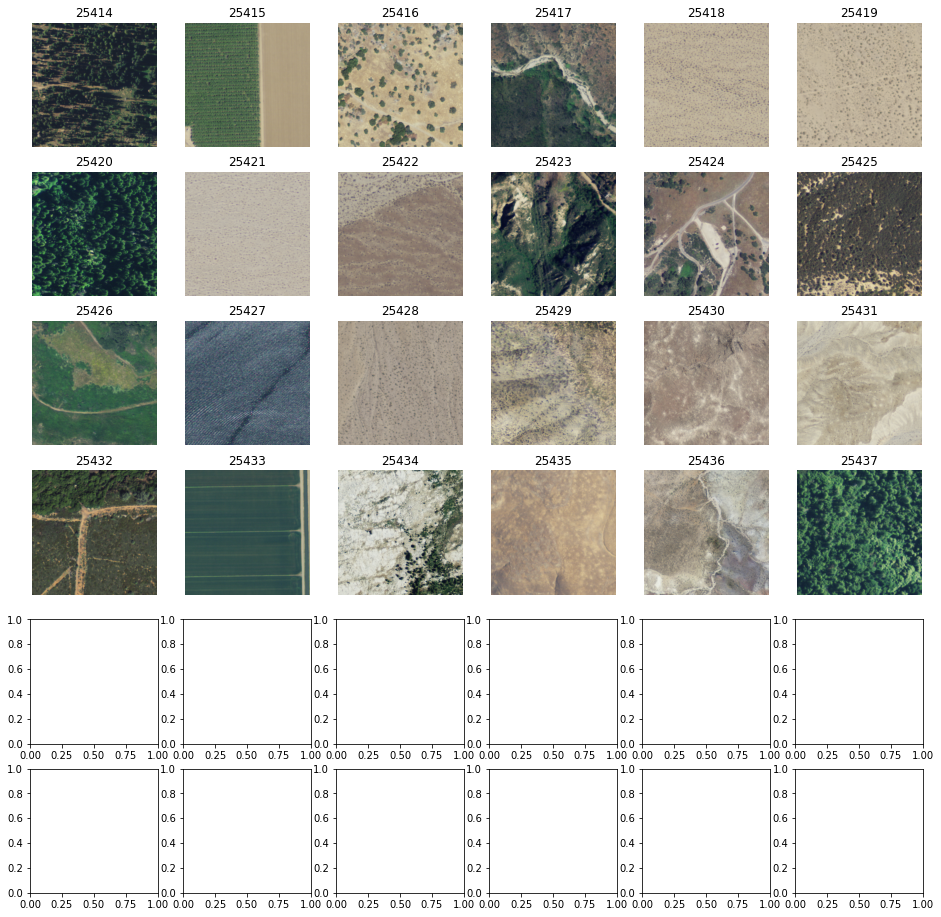

In [17]:
fig, axs = plt.subplots(6, 6, figsize=(16,16), edgecolor='k')
axs = axs.flatten()

for i in range(36):
    axs[i].imshow(image_crops[i][:,:,:3])
    axs[i].axis('off')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].set_aspect('equal')
    axs[i].set_title(labels[i])

plt.suptitle(f'A sample from {query}', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()
plt.close()
